# Minplus algebra experiment

This code attempts to learn the 2D mixture prior
$J(x) = min(\frac{1}{2t\sigma_{1}}||x-\mu_{1}||^{2}, \frac{1}{2\sigma_{2}}||x-\mu_{2}||^{2})$
assuming we have access to training data $\{y_i, S(y_i)\} = min_{x \in \R} \ \{0.5||x-y_i||^{2}_{2} + J(x)\}\}$.

## Import modules 

In [1]:
import os
import numpy as np
import torch

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import seaborn as sns

from network import LPN
from lib.utils import cvx
from lib.invert import invert

# set location
MODEL_DIR = "experiments/models/minplus_2D"
os.makedirs(MODEL_DIR, exist_ok=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# set random seeds
np.random.seed(1)
torch.manual_seed(1)

# plotting options
plt.rcParams.update({"text.usetex": False})
sns.set_theme()

# Utility functions and plotting tools

In [2]:
##############################
#----- Utlity functions -----#
##############################

# Elementary functions, with the axis specified.
def euclid_norm(x):
    return np.linalg.norm(x, ord = 2, axis = 1)


def inner_prod(x,y):
    return np.sum(x*y, axis = 1)

def euclid_norm_sq(x):
    if x.ndim == 1:
        return np.sum(x*x)
    return np.sum(x * x, axis=1)


def exp_func(x, gamma):
    ''' Proximal matching loss -- x |-> 1 - exp(-(||x||_{2}^{2}/gamma)^{2})
        for training learned proximal networks.
    '''
    return -torch.exp(-((torch.linalg.vector_norm(x, ord = 2, dim = 1)/ gamma) ** 2)) + 1.0


def hjsol_true(y,mu1,mu2,sigma1,sigma2):
    '''This function computes the solution S(y,t) of the Hamilton--Jacobi
    PDE for the minplus algebra example at t = 1.

    Args:
        y:      An n-dimensional numpy array of numbers
        mu1:    An n-dimensional numpy array of numbers
        mu2:    An n-dimensional numpy array of numbers
        sigma1: A positive number
        sigma2: A positive number
    Returns:
        hjsol:  An n-dimensional numpy array of numbers
    '''

    val1 = 0.5*pow(euclid_norm(y-mu1),2)/(1+sigma1)
    val2 = 0.5*pow(euclid_norm(y-mu2),2)/(1+sigma2)
    hjsol = np.minimum(val1,val2)
    return hjsol


def prior_true(y,mu1,mu2,sigma1,sigma2):
    '''This function computes the initial data of the Hamilton--Jacobi
    PDE for the minplus algebra example.

    Args:
        y:      An n-dimensional numpy array of numbers
        mu1:    An n-dimensional numpy array of numbers
        mu2:    An n-dimensional numpy array of numbers
        sigma1: A positive number
        sigma2: A positive number
    Returns:
        prior:  An n-dimensional numpy array of numbers
    '''
        
    val1 = 0.5*pow(euclid_norm(y-mu1),2)/sigma1
    val2 = 0.5*pow(euclid_norm(y-mu2),2)/sigma2
    prior = np.minimum(val1,val2)
    return prior


def cvx_true(y,mu1,mu2,sigma1,sigma2):
    '''This function computes 0.5*norm(y)_{2}^{2} - S(y,t) at t = 1.

    Args:
        y:      An n-dimensional numpy array of numbers
        mu1:    An n-dimensional numpy array of numbers
        mu2:    An n-dimensional numpy array of numbers
        sigma1: A positive number
        sigma2: A positive number
    Returns:
        cvx:  An n-dimensional numpy array of numbers
    '''

    cvx = 0.5*pow(euclid_norm(y),2) - hjsol_true(y,mu1,mu2,sigma1,sigma2)
    return cvx


def invert_prior(x, model, INVERT_MODE):
    ''' This function inverts the learned prior at a set of query points x.
    That is, we compute the points y for which nabla_{y}psi(y) = x, 
    where nabla_{y}*psi denotes the gradient of the LPN network.

        Args:
            x:              A numpy array of real numbers at which to invert the prior.
            model:          The trained LPN model object.
            INVERT_MODE:    The method for inverting the LPN network.

        Returns:    y:      The (approximate) set of points for which nabla_{y}psi(y) = x,
                            as a numpy array.
    '''

    y = invert(x,model,INVERT_MODE)
    return y


def evaluate_learned_prior(x, y, model, INVERT_MODE):
    ''' This function evaluates the learned prior at the points y obtained from
    inverting the prior, that is, for which nabla_{y}psi(y) = x, where nabla_{y}psi denotes
    the gradient of the LPN network.
    
    Args:
            x:              A numpy array of real numbers at which to invert the prior.
            model:          The trained LPN model object.
            INVERT_MODE:    The method for inverting the LPN network.

    Returns:    prior_est   The learned initial data (prior) of the HJ PDE at the points x.
    '''

    psi = model.scalar(torch.tensor(y).float().to(device)).squeeze(1).detach().cpu().numpy()
    prior_est = np.sum(x*y, axis = 1) - 0.5 * euclid_norm(x) - psi

    return prior_est

############################
#----- Plotting tools -----#
############################

def compute_square_cross_sections(a, spacing, dim):
    ''' Compute the cross sections (xi,0,...,0) and (0,xi,0,...,0) 
    on the grid [-a,a]^{dim} along the first and second dimensions.

    Args:       a:      A positive number
                spacing: Number of grid spacing along [-a,a]
                dim:    Dimension of the Hamilton--Jacobi PDE

    Returns:    xi:             The numpy array np.linspace(-a, a, spacing)

                x1_0_points:    k x dim numpy array of points, where
                                x_1_0_points[:,0] = np.linspace(-a, a, spacing)
                                with the rest of the entries equal to 0, and
                                k = xi.size

                x2_0_points:    k x dim numpy array of points, where
                                x_2_0_points[:,1] = np.linspace(-a, a, spacing)
                                with the rest of the entries equal to 0, and
                                k = xi.size
    '''

    xi = np.linspace(-a,a,spacing)
    grid = np.zeros((xi.size, dim))
    x1_0_points = np.copy(grid); x1_0_points[:,0] = xi
    x2_0_points = np.copy(grid); x2_0_points[:,1] = xi

    return xi, x1_0_points, x2_0_points


def cross_sections_plots(model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim):
    ''' Compare the true solution of the Hamilton--Jacobi PDE vs the LPN model
        on a square grid [-a,a]^{dim} by overlaying their cross sections along the first and second axes.

    Args:
            model:          The trained LPN model object.
            a:              Measure of the grid [-a,a]^{dim}
            spacing:        Number of points in the interval [-a,a]
            mu1, mu2:       n-dimensional numpy arrays for specifying the initial data
            sigma1, sigma2: Positive numbers for specifying the initial data
            INVERT_MODE:    The method for inverting the LPN network.
            dim:            Spatial dimension of the problem
    '''

    # Compute the cross sections in the first and second axes of the grid [-a,a]^{dim}. 
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)

    # Compute the true initial data and convex functions at the cross section points
    x1_0_cvx_true = cvx_true(x1_0_points,mu1,mu2,sigma1,sigma2)
    x2_0_cvx_true = cvx_true(x2_0_points,mu1,mu2,sigma1,sigma2)

    x1_0_prior_true = prior_true(x1_0_points,mu1,mu2,sigma1,sigma2)
    x2_0_prior_true = prior_true(x2_0_points,mu1,mu2,sigma1,sigma2)

    # Compute the learned initial data and convex functions at the cross section points
    x1_0_cvx_est = cvx(x1_0_points,model)
    x2_0_cvx_est = cvx(x2_0_points,model)
    
    y1 = invert(x1_0_points,model,INVERT_MODE)
    y2 = invert(x2_0_points,model,INVERT_MODE)
    x1_0_prior_est = evaluate_learned_prior(x1_0_points, y1, model, INVERT_MODE)
    x2_0_prior_est = evaluate_learned_prior(x2_0_points, y2, model, INVERT_MODE)

    # Plot cross sections of the convex function
    plt.subplots()
    plt.plot(xi, x1_0_cvx_est, "-", ms=5,label="LPN")
    plt.plot(xi, x1_0_cvx_true, "-", ms=5,label="Ref")
    plt.grid("on")
    plt.title("Cross sections ($x_1$,0) of the convex function")
    plt.xlabel('$x_1$')
    plt.ylabel('Convex functions ($x_1$,0)')
    plt.legend()

    plt.subplots()
    plt.plot(xi, x2_0_cvx_est, "-", ms=5,label="LPN")
    plt.plot(xi, x2_0_cvx_true, "-", ms=5,label="Ref")
    plt.grid("on")
    plt.title("Cross sections (0,$x_2$) of the convex function")
    plt.xlabel('$x_2$')
    plt.ylabel('Convex functions (0, $x_2$)')
    plt.legend()

    # Plot cross sections of the prior function
    plt.subplots()
    plt.plot(xi, x1_0_prior_est, "-", label="LPN")
    plt.plot(xi, x1_0_prior_true, "-", label="Ref")
    plt.grid("on")
    plt.title("Cross sections ($x_1$,0) of the prior function")
    plt.xlabel('$x_1$')
    plt.ylabel('Prior functions ($x_1$,0)')
    plt.legend()

    plt.subplots()
    plt.plot(xi, x2_0_prior_est, "-", label="LPN")
    plt.plot(xi, x2_0_prior_true, "-", label="Ref")
    plt.grid("on")
    plt.title("Cross sections (0,$x_2$) of the prior function")
    plt.xlabel('$x_2$')
    plt.ylabel('Prior functions (0, $x_2$)')
    plt.legend()




def plot_all(model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim):

    # Plot cross sections of the HJ PDEs vs learned proximal network along the first and second dimensions.
    cross_sections_plots(model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim)

## Parameters

In [3]:
# Dimension
dim = 2

# Prior parameters
mu1 = np.zeros(dim); mu1[0] = 1.0;  sigma1 = 1.0
mu2 = np.ones(dim)/np.sqrt(dim);    sigma2 = 1.0

# Define the spatial grid [-a,a]^{dim}
a, spacing = 4, 100

# Number of samples from the solution we have access to
data_points = 20000
Iterations = 30000

# LPN model parameters
# Note: The defaults parameters are beta = 10, hidden = 50, layers = 4
beta = 10       # beta of softplus
hidden = 128     # number of hidden units
layers = 6      # number of layers

# optimization algorithm to use for computing the prior (cvx_cg, cvx_gd)
INVERT_MODE = "cvx_gd"

## Generate training data

In [4]:
# Generate samples {yi} uniformly in the grid [-a,a]^{dim}
input = np.zeros((dim,data_points))

if(dim>1):
    for k in range(0,dim):
        input[k] = np.random.uniform(-a,a,data_points)
else:
    input = np.random.uniform(-a,a,data_points)

input = input.reshape(data_points,dim)

# Generate the samples
cvx_samples = cvx_true(input,mu1,mu2,sigma1,sigma2).reshape(data_points,-1)

# Recast the samples as tensors
input = torch.from_numpy(input).float()
cvx_samples = torch.from_numpy(cvx_samples).float()

# --- ADD THIS TO MOVE DATA TO GPU ---
input = input.to(device)
cvx_samples = cvx_samples.to(device)

## Training function

In [5]:
def single_iteration(i, data_points, lpn_model, optimizer, input,cvx_samples,loss_type, gamma_loss=None):
    # Compute the convex function from the input.
    cvx_out = lpn_model.scalar(input)

    # Calculate the loss function
    if loss_type == 2:
        loss = (cvx_out - cvx_samples).pow(2).sum() / data_points   # MSE loss
    elif loss_type == 1:
        loss = (cvx_out - cvx_samples).abs().sum() / data_points    # MAE loss
    elif loss_type == 0:
        loss = exp_func(cvx_out - cvx_samples, gamma_loss).mean()   # proximal matching loss
    else:
        raise ValueError("loss_type must be 0, 1, or 2")


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    lpn_model.wclip()

    # monitor
    # loss_lstar = exp_func(out - target, 0.1).mean()

    if not i % 5000:
        print("iteration", i, "loss", loss.item()) #, "loss_lstar", loss_lstar.item())

# Train

L2 loss -- Train

In [6]:
# initialize
lpn_model = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta).to(device)
optimizer = torch.optim.Adam(lpn_model.parameters(), lr=1e-3)

for i in range(1):
    single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type=2)

for g in optimizer.param_groups:
    g["lr"] = 1e-4
for i in range(Iterations):
    if (i % 20000 == 0) and (i > 0): 
        # Multiply the current learning rate by 1e-1
        for g in optimizer.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")
    single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type=2)


# save the model
torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, "l2.pth"))

iteration 0 loss 18.375322341918945
iteration 0 loss 819833.125


iteration 5000 loss 40.36284255981445


iteration 10000 loss 0.4013620615005493


iteration 15000 loss 0.12183896452188492


Learning rate decreased to 1e-05 at iteration 20000
iteration 20000 loss 0.002989778760820627


iteration 25000 loss 0.0008266292279586196


L2 loss -- Plot

loss -20.231294631958008


loss -115.91708374023438


loss -194.08566284179688


loss -259.433349609375


loss -315.81341552734375


loss -363.3126525878906


loss -402.76824951171875


loss -436.18499755859375


loss -463.84246826171875


loss -487.12762451171875


loss -506.4466247558594


loss -522.1338500976562


loss -535.7299194335938


loss -548.410888671875


loss -560.8140258789062


loss -573.2092895507812


loss -585.6983032226562


loss -598.3106689453125


loss -611.0419921875


loss -623.8729248046875


loss -636.7806396484375


loss -649.7427978515625


loss -662.7409057617188


loss -675.7606201171875


loss -688.79150390625


loss -701.8264770507812


loss -714.8612060546875


loss -727.892578125


loss -740.9191284179688


loss -753.93896484375


loss -766.9520874023438


loss -779.959228515625


loss -792.9601440429688


loss -805.95458984375


loss -818.943115234375


loss -831.92578125


loss -844.9033813476562


loss -857.8759765625


loss -870.84375


loss -883.8070068359375


final mse:  0.13970807194709778
max, min: 18.662046 -19.110981
loss -20.231294631958008


loss -123.3800048828125


loss -197.55892944335938


loss -256.1324157714844


loss -305.76202392578125


loss -348.8479309082031


loss -385.65118408203125


loss -415.87158203125


loss -440.3077392578125


loss -460.7311096191406


loss -477.9989929199219


loss -492.34478759765625


loss -504.8125


loss -516.464599609375


loss -527.9483032226562


loss -539.526123046875


loss -551.2635498046875


loss -563.1508178710938


loss -575.15625


loss -587.2471923828125


loss -599.3956298828125


loss -611.5789794921875


loss -623.7800903320312


loss -635.986328125


loss -648.1885986328125


loss -660.3814697265625


loss -672.5616455078125


loss -684.727294921875


loss -696.878662109375


loss -709.0157470703125


loss -721.139404296875


loss -733.25146484375


loss -745.352294921875


loss -757.4423828125


loss -769.5228271484375


loss -781.5970458984375


loss -793.6640625


loss -805.723388671875


loss -817.7757568359375


loss -829.8207397460938


final mse:  0.1151876449584961
max, min: 18.841007 -19.049757


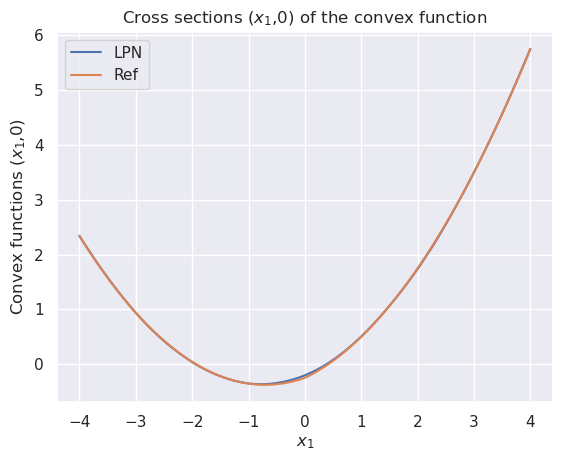

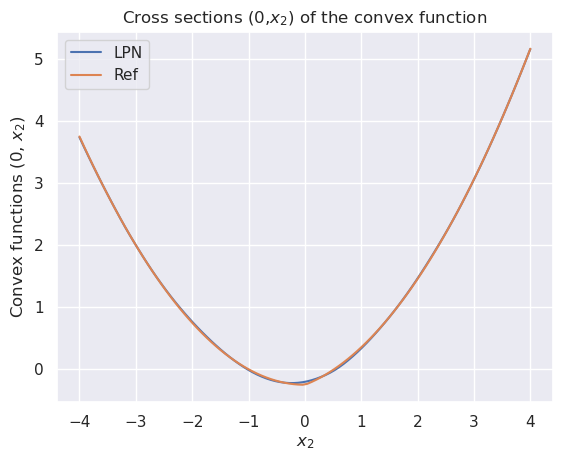

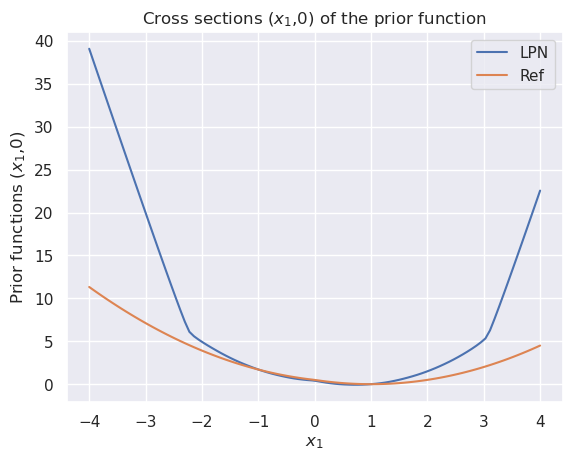

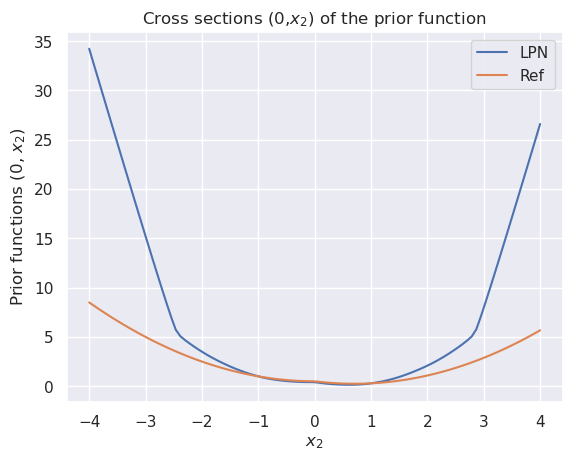

In [7]:
plot_all(lpn_model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim)

In [8]:
# --- Generate New Training Data for the Second LPN G(x) ---
# We use the same x_j_exp_tensor as the first LPN's training data for x_k
x_k_tensor = input.clone().to(device)
x_k_tensor.requires_grad_(True)

# 1. Compute the gradient y_k = grad_x psi_theta(x_k, t=1)
# Get psi(x_k)
psi_x_k = lpn_model.scalar(x_k_tensor)

# Get gradient y_k = grad_psi(x_k)
y_k_tensor = lpn_model(x_k_tensor)

# 2. Evaluate the "new" samples G_k = <y_k, x_k> - psi_theta(x_k, 1) (from eq 26)
inner_prod_yk_xk = torch.sum(y_k_tensor * x_k_tensor, dim=1, keepdim=True)
G_samples_tensor_with_graph = inner_prod_yk_xk - psi_x_k

# Detach the tensor to treat G_k as fixed targets, breaking the connection
# to the first LPN's graph and preventing the RuntimeError during training.
G_samples_tensor = G_samples_tensor_with_graph.detach().to(device)

# The input tensor x_k_tensor is still needed for the second LPN training,
# but it should also not require a gradient for that training.
x_k_tensor = x_k_tensor.detach()
x_k_tensor.requires_grad_(False) 
y_k_tensor = y_k_tensor.detach()
y_k_tensor.requires_grad_(False)
# G_samples_tensor now holds the target values G_k
print(f"Generated G samples: G_samples_tensor shape {G_samples_tensor.shape}")

# --- Step 3: Train LPN G(x) ---
print("\n--- Training Second LPN G(x) for Concave Quadratic Prior ---")
# The target for this LPN is G_samples_tensor
# The input for this LPN is x_k_tensor
lpn_model_G = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta, eps=1e-3).to(device)
optimizer_G = torch.optim.Adam(lpn_model_G.parameters(), lr=1e-4)

# Initial shorter training phase
for i in range(1):
     single_iteration(i, data_points, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

for g in optimizer_G.param_groups:
    g["lr"] = 1e-4 
for i in range(Iterations):
    if (i % 20000 == 0) and (i > 0): 
        # Multiply the current learning rate by 1e-1
        for g in optimizer_G.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")    
    single_iteration(i, data_points, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

torch.save(lpn_model_G.state_dict(), os.path.join(MODEL_DIR, "G_network_l2.pth"))
print("Training of LPN for G(x) complete and model saved.")

Generated G samples: G_samples_tensor shape torch.Size([20000, 1])

--- Training Second LPN G(x) for Concave Quadratic Prior ---
iteration 0 loss 13.483736991882324
iteration 0 loss 163014.546875


iteration 5000 loss 3.80298113822937


iteration 10000 loss 0.4069274961948395


iteration 15000 loss 0.020187603309750557


Learning rate decreased to 1e-05 at iteration 20000
iteration 20000 loss 0.00033970060758292675


iteration 25000 loss 0.00013207980373408645


Training of LPN for G(x) complete and model saved.



--- Plotting Estimated Prior J(x) from 2nd LPN---


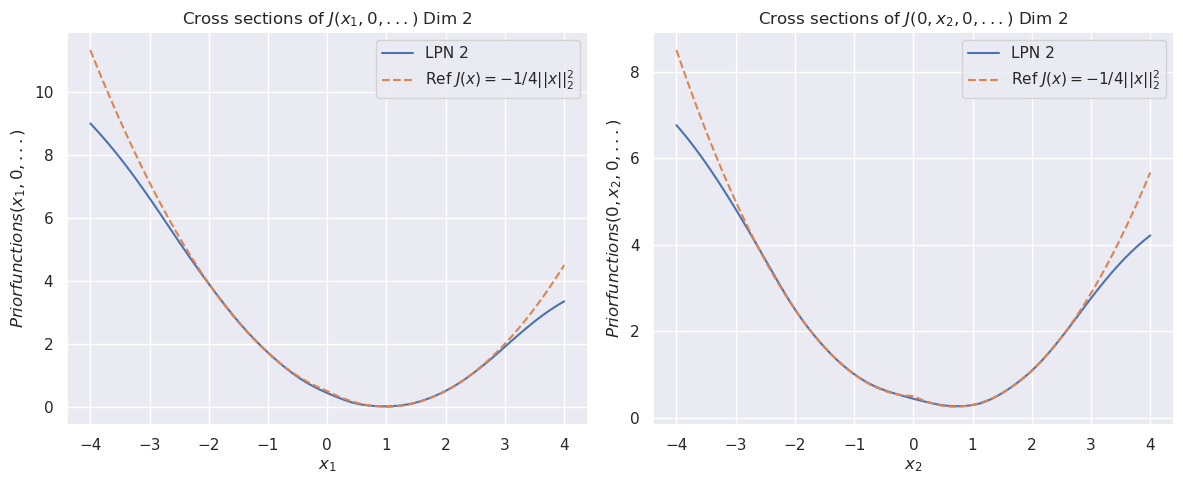

In [9]:
def evaluate_learned_J_G_network(x_points, model_G):
    """
    Evaluates the learned prior J(x) using the trained G(x) network.
    J(x) = G(x) - 0.5 * ||x||^2
    """
    # Convert to tensor
    x_tensor = torch.from_numpy(x_points).float().to(device)
    
    # Get G(x) from the second LPN model
    G_x = model_G.scalar(x_tensor)
    
    # Compute 0.5 * ||x||^2
    x_norm_sq_np = euclid_norm_sq(x_points)
    x_norm_sq_tensor = torch.from_numpy(x_norm_sq_np).float().to(device).reshape(-1, 1)

    # Apply the formula: J_est = G(x) - 0.5 * ||x||^2
    J_est = G_x - 0.5 * x_norm_sq_tensor
    
    # Convert back to numpy
    J_est_np = J_est.detach().cpu().numpy().flatten()
    
    return J_est_np

def plot_J_G_network(model_G, a, spacing, dim,mu1,mu2,sigma1,sigma2):
    """Plots the cross-sections of the estimated prior J(x) from the G network."""
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    # True Prior
    x1_0_J_true = prior_true(x1_0_points,mu1,mu2,sigma1,sigma2)
    if dim > 1:
        x2_0_J_true = prior_true(x2_0_points,mu1,mu2,sigma1,sigma2)
    else:
        x2_0_J_true = x1_0_J_true
        
    # Estimated Prior from G(x) Network
    x1_0_J_G_est = evaluate_learned_J_G_network(x1_0_points, model_G)
    if dim > 1:
        x2_0_J_G_est = evaluate_learned_J_G_network(x2_0_points, model_G)
    else:
        x2_0_J_G_est = x1_0_J_G_est
    
    print("\n--- Plotting Estimated Prior J(x) from 2nd LPN---")
    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_G_est, "-", label="LPN 2")
    plt.plot(xi, x1_0_J_true, "--", label="Ref $J(x)=-1/4||x||_2^2$")
    plt.grid(True)
    plt.title(f"Cross sections of $J(x_1,0,...)$ Dim {dim}")
    plt.xlabel('$x_1$')
    plt.ylabel('$Prior functions (x_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_G_est, "-", label="LPN 2")
        plt.plot(xi, x2_0_J_true, "--", label="Ref $J(x)=-1/4||x||_2^2$")
        plt.grid(True)
        plt.title(f"Cross sections of $J(0,x_2,0,...)$ Dim {dim}")
        plt.xlabel('$x_2$')
        plt.ylabel('$Prior functions (0,x_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    #plt.savefig('G_network_prior_plot.png')
    
# --- Execute Plotting ---
plot_J_G_network(lpn_model_G, a, spacing, dim,mu1,mu2,sigma1,sigma2)